In [1]:
# requirements
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# dataset 4
n = 200
x_d4 = 3 * (np.random.rand(n, 4) - 0.5)
y_d4 = (2 * x_d4[:, 0] - 1 * x_d4[:,1] + 0.5 + 0.5 * np.random.randn(n)) > 0
y_d4 = 2 * y_d4 -1

In [3]:
class AdaGrad:
    accum = 0
    
    def __init__(self, learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07):
        self.learning_rate = learning_rate
        AdaGrad.accum += initial_accumulator_value
        self.epsilon = epsilon
    
    def delta(self, grad):
        AdaGrad.accum += grad*grad
        sqrt = np.sqrt(AdaGrad.accum + self.epsilon)
        return self.learning_rate/sqrt*grad

In [4]:
class Adam:
    m = 0
    v = 0
    beta_1_t = 1
    beta_2_t = 1
    
    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07):
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
    
    def delta(self, grad):
        Adam.m = self.beta_1*Adam.m + (1 - self.beta_1)*grad
        Adam.v = self.beta_2*Adam.v + (1 - self.beta_2)*grad*grad
        Adam.beta_1_t *= self.beta_1
        Adam.beta_2_t *= self.beta_2
        mh = Adam.m/(1 - Adam.beta_1_t)
        vh = Adam.v/(1 - Adam.beta_2_t)
        v_sqrt = np.sqrt(vh) + self.epsilon
        return self.learning_rate*mh/v_sqrt

In [5]:
class AdaDelta:
    s = 0
    delta_x = 0
    
    def __init__(self, learning_rate=0.001, rho=0.95, epsilon=1e-07):
        self.learning_rate = learning_rate
        self.rho = rho
        self.epsilon = epsilon
    
    def delta(self, grad):
        AdaDelta.s = self.rho*AdaDelta.s + (1 - self.rho)*grad*grad
        g = (np.sqrt(AdaDelta.delta_x + self.epsilon)/np.sqrt(AdaDelta.s + self.epsilon))*grad
        AdaDelta.delta_x = self.rho*AdaDelta.delta_x + (1 - self.rho)*g*g
        return g

In [6]:
class RMSprop:
    s = 0
    delta_x = 0
    
    def __init__(self, learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07):
        self.learning_rate = learning_rate
        self.rho = rho
        self.momentum = momentum
        self.epsilon = epsilon
    
    def delta(self, grad):
        RMSprop.s = self.rho*RMSprop.s + (1 - self.rho)*grad*grad
        return self.learning_rate/np.sqrt(RMSprop.s + self.epsilon)*grad

In [7]:
class Adamax:
    m = 0
    v = 0
    beta_1_t = 1
    flag = False
    
    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07):
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
    
    def delta(self, grad):
        Adamax.m = self.beta_1*Adamax.m + (1 - self.beta_1)*grad
        '''if Adamax.flag == False:
            Adamax.v = np.zeros_like(grad)
            flag = True
        for i in range(len(grad)):
            Adamax.v[i] = max(np.abs(grad[i]), Adamax.v[i]*self.beta_2)'''
        Adamax.v = max(np.linalg.norm(grad, ord=2), Adamax.v*self.beta_2)
        Adamax.beta_1_t *= self.beta_1
        mh = Adamax.m/(1 - Adamax.beta_1_t)
        return self.learning_rate*mh/(Adamax.v + self.epsilon)

In [8]:
class Nadam:
    m = 0
    v = 0
    t = 0
    mu = 1
    beta_2_t = 1
    
    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07):
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
    
    def delta(self, grad):
        Nadam.t += 1
        mut = self.beta_1*(1 - 0.5*0.96**(0.004*Nadam.t))
        Nadam.mu *= mut
        gh = grad/(1 - Nadam.mu)
        Nadam.m = self.beta_1*Nadam.m + (1 - self.beta_1)*grad
        Nadam.v = self.beta_2*Nadam.v + (1 - self.beta_2)*grad*grad
        Nadam.beta_2_t *= self.beta_2
        mh = Nadam.m/(1 - Nadam.mu)
        vh = Nadam.v/(1 - Nadam.beta_2_t)
        mb = (1 - mut)*gh + self.beta_1*(1 - 0.5*0.96**(0.004*(Nadam.t + 1)))*mh
        v_sqrt = np.sqrt(vh) + self.epsilon
        return self.learning_rate*mb/v_sqrt

In [9]:
w = np.zeros(2)
A = np.array([[250, 15], [15, 4]])
m = np.array([1, 2])
print(w, A, m)

[0. 0.] [[250  15]
 [ 15   4]] [1 2]


In [10]:
rate = 1/(np.max(np.linalg.eig(2*A)[0])*1.01)
lamda = 0.89
print(rate)

0.0019730063440560213


In [11]:
def PGforLasso(lr):
    # w = np.zeros(2)
    w = np.array([3., -1.])
    w_list = [np.copy(w)]
    times = 0
    while 1:
        dw = np.zeros_like(w)
        w_temp = np.copy(w)
        dw = 2*np.dot(A, (w - m).T)
        d = lr.delta(dw)
        w -= d
        l = lamda*d/dw
        for i in range(len(w)):
            if w[i] > l[i]:
                w[i] -= l[i]
            elif w[i] < -l[i]:
                 w[i] += l[i]
            else:
                w[i] = 0
        w_list.append(np.copy(w))
        if np.all(w == w_temp) or times == 10000 or (times > 0 and np.linalg.norm(w_list[-2] - w_list[-1], ord=1) < 1e-5):
            print(w)
            break
        times += 1
    print(times)        
    w_list = np.array(w_list)
    w_path_list = np.copy(w_list[:-1])
    w_list = w_list[:-1] - w_list[-1]
    w_list = [np.linalg.norm(i, ord=2) for i in w_list]
    
    x = [i for i in range(len(w_list))]
    plt.semilogy(x, w_list)
    plt.show()
    
    plt.plot(w_path_list[0:-1, 0], w_path_list[0:-1, 1], 'x-')
    plt.plot(w_path_list[-1, 0], w_path_list[-1, 1], 'ro')
    plt.show()
    
    return np.copy(w_list)

AdaGrad
[1.00632212 1.86498511]
102


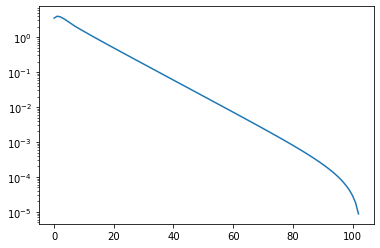

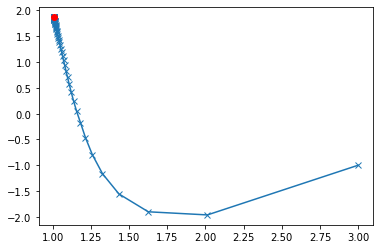

Adam
[1.00635925 1.86453263]
824


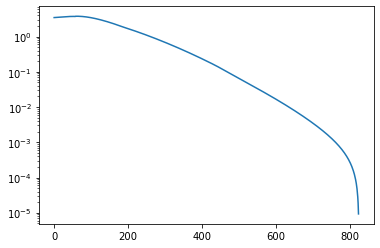

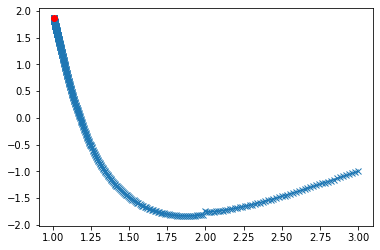

AdaDelta
[1.00636405 1.86427384]
2499


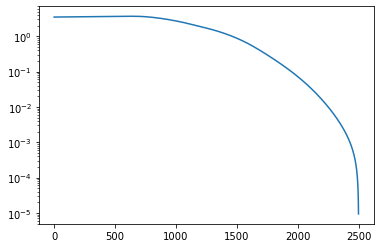

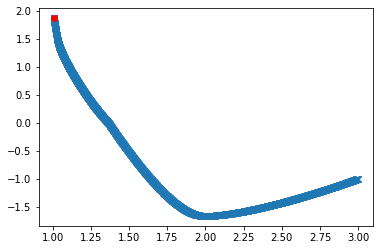

Adamax
[1.00638817 1.86387865]
4068


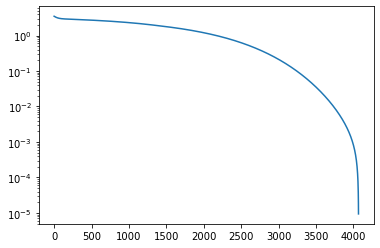

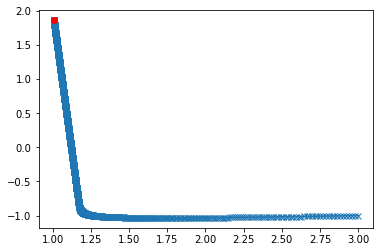

Nadam
[1.00635989 1.86453609]
843


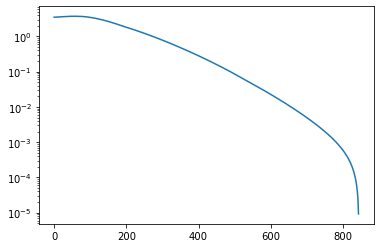

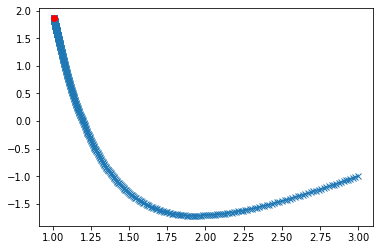

In [13]:
method = [AdaGrad(learning_rate=500*rate), Adam(learning_rate=10*rate), \
          AdaDelta(learning_rate=500*rate), Adamax(learning_rate=10*rate), Nadam(learning_rate=10*rate)]
method_name = ['AdaGrad', 'Adam', 'AdaDelta', 'Adamax', 'Nadam']
w_list = []
for i in range(len(method)):
    print(method_name[i])
    temp = PGforLasso(method[i])
    w_list.append(temp)

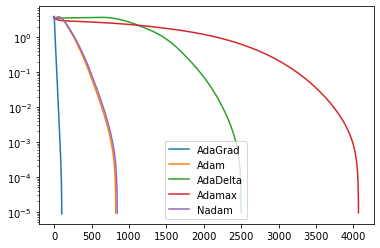

In [14]:
for i in range(len(w_list)):
    x = [i for i in range(len(w_list[i]))]
    plt.semilogy(x, w_list[i], label=method_name[i])
plt.legend()
plt.show()

[1.00632252 1.8649803 ]
100


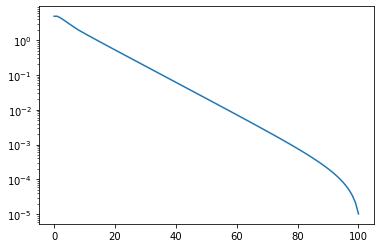

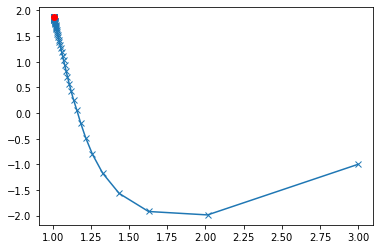

In [67]:
# w = np.zeros(2)
w = np.array([3., -1.])
w_list = [np.copy(w)]
times = 0
lr = AdaGrad(learning_rate=500*rate)
# l = lamda*rate
# print(l)
while 1:
    dw = np.zeros_like(w)
    w_temp = np.copy(w)
    dw = 2*np.dot(A, (w - m).T)
    '''r = lr.rate(dw)
    w -= r*dw
    l = lamda*r
    for i in range(len(w)):
        if w[i] > l[i]:
            w[i] -= l[i]
        elif w[i] < -l[i]:
             w[i] += l[i]
        else:
            w[i] = 0'''
    for i in range(len(w)):
        if w[i] > 0:
            dw[i] += lamda
        elif w[i] < 0:
            dw[i] -= lamda
    w -= lr.delta(dw)
    
    w_list.append(np.copy(w))
    if np.all(w == w_temp) or times == 1000 or (times > 0 and np.linalg.norm(w_list[-2] - w_list[-1], ord=2) < 1e-5):
        print(w)
        break
    times += 1
print(times)        
w_list = np.array(w_list)
w_path_list = np.copy(w_list[:-1])
w_list = w_list[:-1] - w_list[-1]
w_list = [np.linalg.norm(i, ord=1) for i in w_list]
    
x = [i for i in range(len(w_list))]
plt.semilogy(x, w_list)
plt.show()
    
plt.plot(w_path_list[0:-1, 0], w_path_list[0:-1, 1], 'x-')
plt.plot(w_path_list[-1, 0], w_path_list[-1, 1], 'ro')
plt.show()

[1.00635442 1.86459683]
774


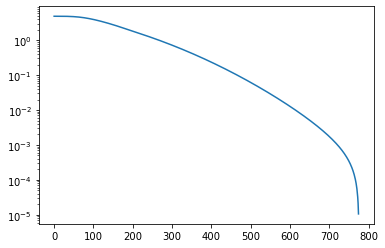

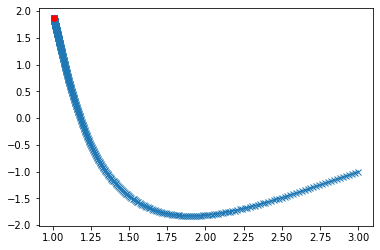

In [68]:
# w = np.zeros(2)
w = np.array([3., -1.])
w_list = [np.copy(w)]
times = 0
lr = Adam(learning_rate=10*rate)
# l = lamda*rate
# print(l)
while 1:
    dw = np.zeros_like(w)
    w_temp = np.copy(w)
    dw = 2*np.dot(A, (w - m).T)
    # print(w)
    # l = lamda*r/dw
    # print(l)
    for i in range(len(w)):
        if w[i] > 0:
            dw[i] += lamda
        elif w[i] < 0:
            dw[i] -= lamda
    w -= lr.delta(dw)
    w_list.append(np.copy(w))
    if np.all(w == w_temp) or times == 20000 or (times > 0 and np.linalg.norm(w_list[-2] - w_list[-1], ord=2) < 1e-5):
        print(w)
        break
    times += 1
print(times)        
w_list = np.array(w_list)
w_path_list = np.copy(w_list[:-1])
w_list = w_list[:-1] - w_list[-1]
w_list = [np.linalg.norm(i, ord=1) for i in w_list]
    
x = [i for i in range(len(w_list))]
plt.semilogy(x, w_list)
plt.show()
    
plt.plot(w_path_list[0:-1, 0], w_path_list[0:-1, 1], 'x-')
plt.plot(w_path_list[-1, 0], w_path_list[-1, 1], 'ro')
plt.show()

[1.00632157 1.8649784 ]
340


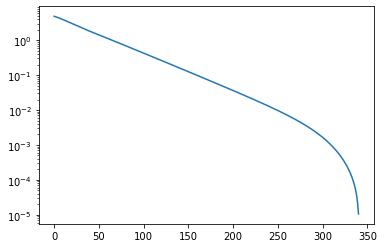

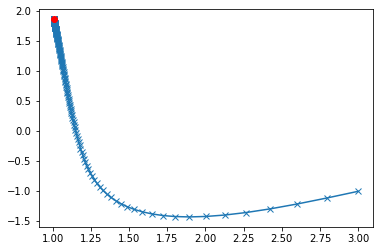

In [14]:
# w = np.zeros(2)
w = np.array([3., -1.])
w_list = [np.copy(w)]
times = 0
lr = AdaDelta(learning_rate=10*rate)
# l = lamda*rate
# print(l)
while 1:
    dw = np.zeros_like(w)
    w_temp = np.copy(w)
    dw = 2*np.dot(A, (w - m).T)
    # print(w)
    # l = lamda*r/dw
    # print(l)
    for i in range(len(w)):
        if w[i] > 0:
            dw[i] += lamda
        elif w[i] < 0:
            dw[i] -= lamda
    w -= lr.delta(dw)
    w_list.append(np.copy(w))
    if np.all(w == w_temp) or times == 1000 or (times > 0 and np.linalg.norm(w_list[-2] - w_list[-1], ord=2) < 1e-5):
        print(w)
        break
    times += 1
print(times)        
w_list = np.array(w_list)
w_path_list = np.copy(w_list[:-1])
w_list = w_list[:-1] - w_list[-1]
w_list = [np.linalg.norm(i, ord=1) for i in w_list]
    
x = [i for i in range(len(w_list))]
plt.semilogy(x, w_list)
plt.show()
    
plt.plot(w_path_list[0:-1, 0], w_path_list[0:-1, 1], 'x-')
plt.plot(w_path_list[-1, 0], w_path_list[-1, 1], 'ro')
plt.show()

[1.00635141 1.86448383]
754


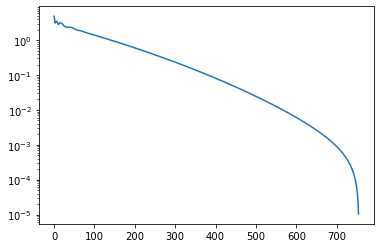

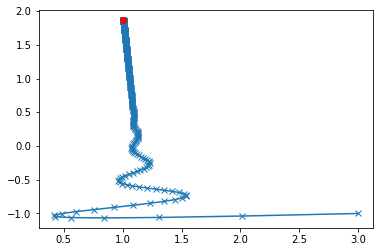

In [70]:
# w = np.zeros(2)
w = np.array([3., -1.])
w_list = [np.copy(w)]
times = 0
lr = Adamax(learning_rate=500*rate)
# l = lamda*rate
# print(l)
while 1:
    dw = np.zeros_like(w)
    w_temp = np.copy(w)
    dw = 2*np.dot(A, (w - m).T)
    # print(w)
    # l = lamda*r/dw
    # print(l)
    for i in range(len(w)):
        if w[i] > 0:
            dw[i] += lamda
        elif w[i] < 0:
            dw[i] -= lamda
    w -= lr.delta(dw)
    w_list.append(np.copy(w))
    if np.all(w == w_temp) or times == 20000 or (times > 0 and np.linalg.norm(w_list[-2] - w_list[-1], ord=2) < 1e-5):
        print(w)
        break
    times += 1
print(times)        
w_list = np.array(w_list)
w_path_list = np.copy(w_list[:-1])
w_list = w_list[:-1] - w_list[-1]
w_list = [np.linalg.norm(i, ord=1) for i in w_list]
    
x = [i for i in range(len(w_list))]
plt.semilogy(x, w_list)
plt.show()
    
plt.plot(w_path_list[0:-1, 0], w_path_list[0:-1, 1], 'x-')
plt.plot(w_path_list[-1, 0], w_path_list[-1, 1], 'ro')
plt.show()

[1.00635894 1.86455315]
811


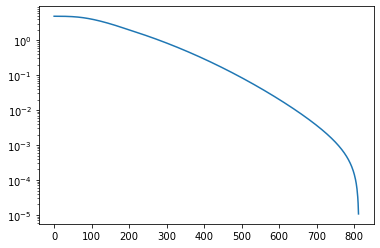

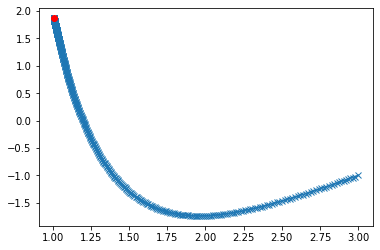

In [71]:
# w = np.zeros(2)
w = np.array([3., -1.])
w_list = [np.copy(w)]
times = 0
lr = Nadam(learning_rate=10*rate)
# l = lamda*rate
# print(l)
while 1:
    dw = np.zeros_like(w)
    w_temp = np.copy(w)
    dw = 2*np.dot(A, (w - m).T)
    # print(w)
    # l = lamda*r/dw
    # print(l)
    for i in range(len(w)):
        if w[i] > 0:
            dw[i] += lamda
        elif w[i] < 0:
            dw[i] -= lamda
    w -= lr.delta(dw)
    w_list.append(np.copy(w))
    if np.all(w == w_temp) or times == 20000 or (times > 0 and np.linalg.norm(w_list[-2] - w_list[-1], ord=2) < 1e-5):
        print(w)
        break
    times += 1
print(times)        
w_list = np.array(w_list)
w_path_list = np.copy(w_list[:-1])
w_list = w_list[:-1] - w_list[-1]
w_list = [np.linalg.norm(i, ord=1) for i in w_list]
    
x = [i for i in range(len(w_list))]
plt.semilogy(x, w_list)
plt.show()
    
plt.plot(w_path_list[0:-1, 0], w_path_list[0:-1, 1], 'x-')
plt.plot(w_path_list[-1, 0], w_path_list[-1, 1], 'ro')
plt.show()

In [23]:
def test():
    # w = np.zeros(2)
    w = np.array([3., -1.])
    w_list = [np.copy(w)]
    times = 0
    lr = AdaDelta(learning_rate=10*rate, rho=0.9)
    # l = lamda*rate
    # print(l)
    while 1:
        dw = np.zeros_like(w)
        w_temp = np.copy(w)
        dw = 2*np.dot(A, (w - m).T)
        # print(w)
        # l = lamda*r/dw
        # print(l)
        for i in range(len(w)):
            if w[i] > 0:
                dw[i] += lamda
            elif w[i] < 0:
                dw[i] -= lamda
        w -= lr.delta(dw)
        w_list.append(np.copy(w))
        if np.all(w == w_temp) or times == 1000 or (times > 0 and np.linalg.norm(w_list[-2] - w_list[-1], ord=2) < 1e-5):
            return times
        times += 1
    
    return times

In [24]:
count = 0
for i in range(100):
    t = test()
    if t < 1000:
        count += 1
print(count)

0


In [44]:
def test2():
    # w = np.zeros(2)
    w = 10
    w_list = [np.copy(w)]
    times = 0
    lr = AdaDelta(learning_rate=10*rate)
    # l = lamda*rate
    # print(l)
    while 1:
        dw = np.zeros_like(w)
        w_temp = np.copy(w)
        dw = 2*w
        # print(w)
        # l = lamda*r/dw
        # print(l)
        '''for i in range(len(w)):
            if w[i] > 0:
                dw[i] += lamda
            elif w[i] < 0:
                dw[i] -= lamda'''
        w -= lr.delta(dw)
        # print(w)
        w_list.append(np.copy(w))
        if np.all(w == w_temp) or times == 10000000:
            print(w, times)
            return times
        times += 1
    
    return times

In [45]:
test2()

5.199985545478163e-60 10000000


10000000

[1.20361857 0.32114036]
1000


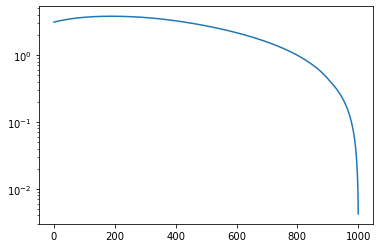

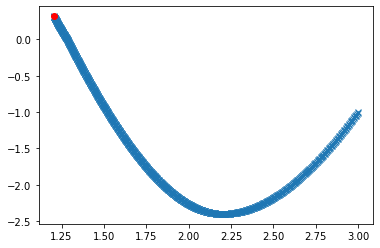

In [54]:
# w = np.zeros(2)
w = np.array([3., -1.])
w_list = [np.copy(w)]
times = 0
lr = AdaDelta(learning_rate=10*rate)
# l = lamda*rate
# print(l)
while 1:
    dw = np.zeros_like(w)
    w_temp = np.copy(w)
    dw = 2*np.dot(A, (w - m).T)
    # print(w)
    # l = lamda*r/dw
    # print(l)
    for i in range(len(w)):
        if w[i] > 0:
            dw[i] += lamda
        elif w[i] < 0:
            dw[i] -= lamda
    w -= lr.delta(dw)
    w_list.append(np.copy(w))
    if np.all(w == w_temp) or times == 1000 or (times > 0 and np.linalg.norm(w_list[-2] - w_list[-1], ord=2) < 1e-5):
        print(w)
        break
    times += 1
print(times)        
w_list = np.array(w_list)
w_path_list = np.copy(w_list[:-1])
w_list = w_list[:-1] - w_list[-1]
w_list = [np.linalg.norm(i, ord=1) for i in w_list]
    
x = [i for i in range(len(w_list))]
plt.semilogy(x, w_list)
plt.show()
    
plt.plot(w_path_list[0:-1, 0], w_path_list[0:-1, 1], 'x-')
plt.plot(w_path_list[-1, 0], w_path_list[-1, 1], 'ro')
plt.show()

[1.1450237  0.40194943]
10000


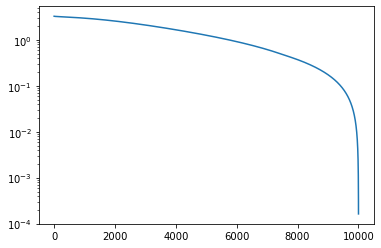

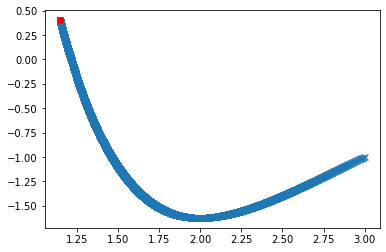

In [43]:
# w = np.zeros(2)
w = np.array([3., -1.])
w_list = [np.copy(w)]
times = 0
lr = AdaGrad(learning_rate=10*rate)
# l = lamda*rate
# print(l)
while 1:
    dw = np.zeros_like(w)
    w_temp = np.copy(w)
    dw = 2*np.dot(A, (w - m).T)
    d = lr.delta(dw)
    w -= d
    l = lamda*d/dw
    for i in range(len(w)):
        if w[i] > l[i]:
            w[i] -= l[i]
        elif w[i] < -l[i]:
             w[i] += l[i]
        else:
            w[i] = 0
    
    w_list.append(np.copy(w))
    if np.all(w == w_temp) or times == 10000 or (times > 0 and np.linalg.norm(w_list[-2] - w_list[-1], ord=2) < 1e-5):
        print(w)
        break
    times += 1
print(times)        
w_list = np.array(w_list)
w_path_list = np.copy(w_list[:-1])
w_list = w_list[:-1] - w_list[-1]
w_list = [np.linalg.norm(i, ord=1) for i in w_list]
    
x = [i for i in range(len(w_list))]
plt.semilogy(x, w_list)
plt.show()
    
plt.plot(w_path_list[0:-1, 0], w_path_list[0:-1, 1], 'x-')
plt.plot(w_path_list[-1, 0], w_path_list[-1, 1], 'ro')
plt.show()